# Tidal Project group C4

## Step 1: Adding & Formatting Data

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [39]:
fname = 'Downloads/ASTR19_S22_group_project_data.txt'
#open the file with read mode
f = open(fname,'r')
#print the name of the file
print(f.name)
#read the data as a string
test_data = f.read()
#print the info from the file
print(test_data)

Downloads/ASTR19_S22_group_project_data.txt
#Column A: Day of the year
#Column B: Time in hours:minutes
#Column B: Tide Height in feet
 1  8:07  6.57
 1 15:37 -0.39
 2  8:55  5.38
 2 16:25 -1.74
 3  9:45  5.26
 3 17:14 -1.36
 4 10:35  4.13
 4 18:00 -1.15
 5 11:28  3.48
 5 18:46 -1.61
 6 12:22  2.62
 6 19:31  0.05
 7 13:24  1.83
 7 20:16  1.01
 8  3:22  3.57
 8 21:01  0.73
 9  4:07  4.54
 9 21:46  2.17
10  4:50  3.76
10 11:58  2.88
11  5:31  3.90
11 12:56  1.92
12  6:08  4.73
12 13:45  1.74
13  6:47  5.66
13 14:25  0.79
14  7:22  5.33
14 15:00 -0.04
15  7:59  5.23
15 15:34 -1.12
16  8:34  6.67
16 16:08 -0.61
17  9:10  4.74
17 16:41 -0.93
18  9:45  4.69
18 17:12 -1.29
19 10:21  4.20
19 17:45  0.22
20 10:57  3.68
20 18:15  0.26
21 11:38  2.47
21 18:48  0.36
22 12:25  2.59
22 19:20  0.99
23  2:22  4.10
23 19:52  1.87
24  2:58  3.17
24 20:30  1.60
25  3:37  3.71
25 10:44  3.10
26  4:23  4.04
26 11:55  2.49
27  5:15  4.07
27 12:57  2.18
28  6:09  5.93
28 13:50  0.70
29  7:05  6.89
29 14:39  

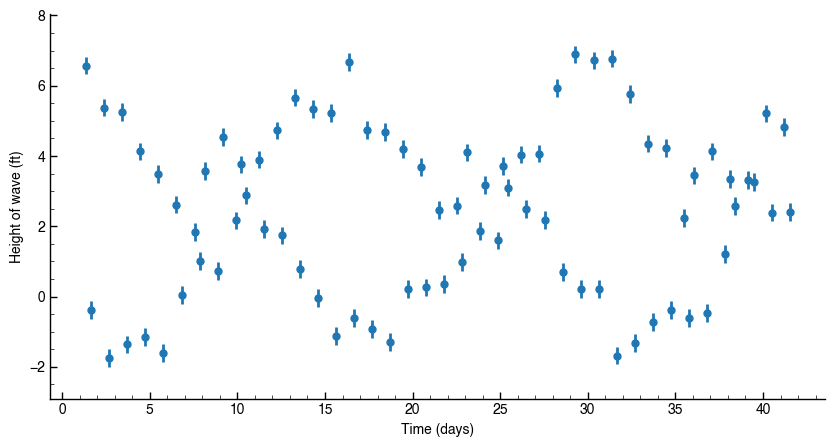

In [29]:
#open the file with numpy loadtxt
test_data = np.loadtxt(fname, dtype={'names': ('day', 'time', 'height'),'formats': ('i4', 'S5', 'f4')})

#format time to be in days then put the x and y values into two separate arrays
result_x = []
result_y = []
for item in test_data:
    day = item [0]
    time = item [1].decode()
    height = item [2]
    Day = (day)
    TimeParts = time.split(":")
    daysfromhour = int(TimeParts[0])/24
    daysfromminutes = int(TimeParts[1])/60/24
    timeindays = day + daysfromhour + daysfromminutes
    x = timeindays
    y = height
    result_x.append(x)
    result_y.append(y)

result_x = np.asarray(result_x)
result_y = np.asarray(result_y)

#format and create a errorbar plot of the data
plt.style.use("Downloads/astr19_matplotlib_defaults.txt")
fig = plt.figure(figsize=(10,5))
ax = plt.subplot
plt.xlabel('Time (days)')
plt.ylabel('Height of wave (ft)')
plt.errorbar(result_x, result_y, yerr= 0.25, fmt='o', label='data')

plt.show()

## Curve Fitting

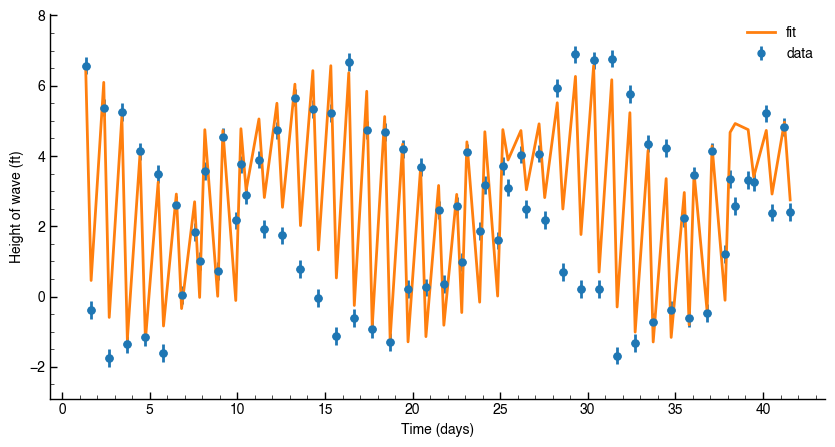

In [37]:
#define the function to fit
def f_line(x, a, b, c, d, e, f):
    return (a * np.sin(((2*np.pi)/1)*x + b+6)) + (1*c * np.sin(((2*np.pi)/0.2)*x + d+6)) * (e * np.sin(((2*np.pi)/0.5)*x + f))

#perform the fit
params, params_cov = optimize.curve_fit(f_line, result_x, result_y, p0=[3, 0.5, 1, 1, 1, 1,]) 

a_fit = params[0]
b_fit = params[1]
c_fit = params[2]
d_fit = params[3]
e_fit = params[4]
f_fit = params[5]

y_fit = (a_fit * np.sin(((np.pi)/0.5)*result_x + b_fit)+2) + (c_fit * np.cos(((2*np.pi)/0.5)*result_x + d_fit)) * (e_fit * np.sin(((2*np.pi)/0.5)*result_x + f_fit))


#plot the fit on the same graph
plt.style.use("Downloads/astr19_matplotlib_defaults.txt")
fig = plt.figure(figsize=(10,5))
ax = plt.subplot
plt.xlabel('Time (days)')
plt.ylabel('Height of wave (ft)')
plt.scatter(result_x, result_y)
plt.errorbar(result_x, result_y, yerr= 0.25, fmt='o', label='data')
plt.plot(result_x, y_fit, label='fit')
plt.legend(loc=0, frameon=False)

#save the figure as a PDF
plt.savefig('project-figure.pdf', bbox_inches='tight', dpi=600)

## Step 3: Plotting Residuals and Statistical Analysis

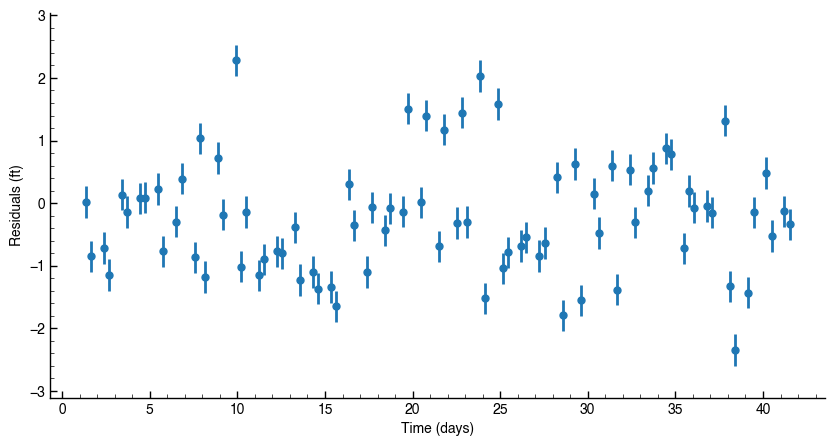

In [31]:
#calculate the residuals
residuals = result_y - y_fit

#make a figure & plot the residuals
plt.figure(figsize=(10,5))
plt.errorbar(result_x, residuals, yerr=0.25, fmt='o', label='residuals')
plt.xlabel('Time (days)')
plt.ylabel('Residuals (ft)')
plt.show()

In [32]:
#Statistical Analysis
residuals_std = np.std(residuals)
mean_residuals = np.mean(residuals)
median_residuals = np.median(residuals)
var_residuals = np.var(residuals)

print(f'Standard Deviation of Residuals: {residuals_std:.4f}')
print(f'Mean of Residuals: {mean_residuals:.4f}')
print(f'Median of Residuals: {median_residuals:.4f}')
print(f'Variance of Residuals: {var_residuals:.4f}')

#calculate the intrinsic scatter of the plot
vscatter = var_residuals - 0.25
print(f'The intrinsic scatter in the data is about {vscatter:.4f}')

Standard Deviation of Residuals: 0.9063
Mean of Residuals: -0.2338
Median of Residuals: -0.3000
Variance of Residuals: 0.8215
The intrinsic scatter in the data is about 0.5715


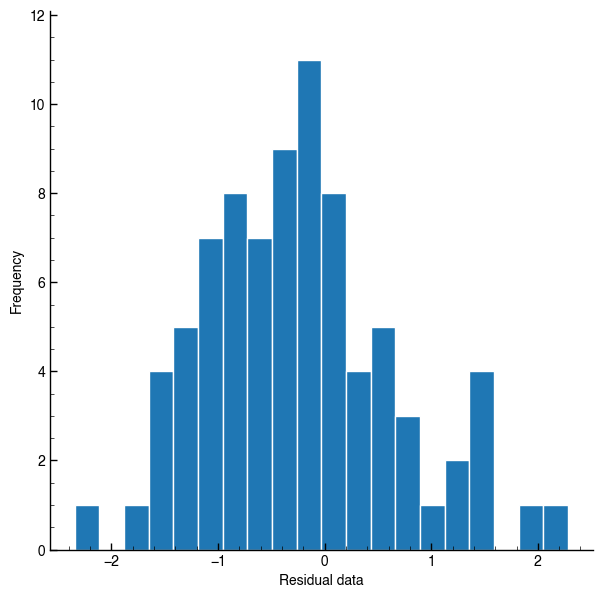

In [36]:
#Plot the residuals on a histogram 
plt.figure(figsize=(7, 7))
plt.hist(residuals, bins=20, edgecolor='white', label = "residual histogram")
plt.xlabel('Residual data')
plt.ylabel('Frequency')
plt.show()

#save the figure as a PDF
plt.savefig('project-residual-histogram.pdf', bbox_inches='tight', dpi=600)

1. Is the scatter in the data larger than the assumed experimental error?

Yes, the scatter is larger than the assumed experimental error of 0.25. The scatter is roughly from -2,2.

## Step 4: Outlier Plotting & Analysis

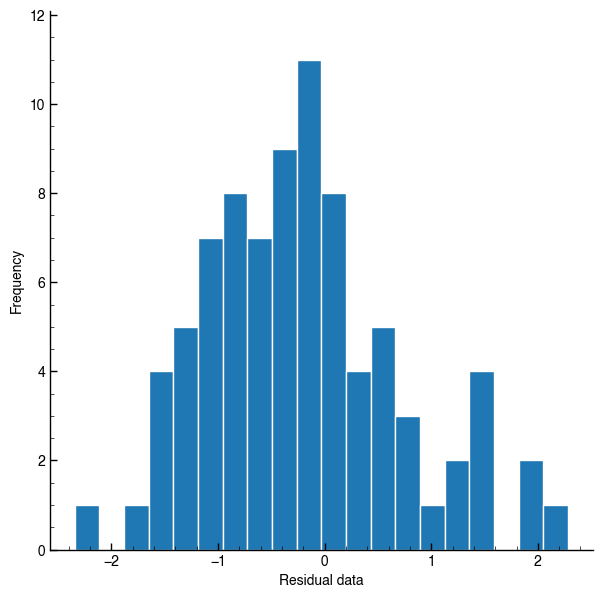

In [34]:
#Add the outlier to the data in an array
outlier_data = np.append([residuals], [2])

#plot a histogram with the new data
plt.figure(figsize=(7, 7))
plt.hist(outlier_data, bins=20, edgecolor='white', label = "outlier histogram")
plt.xlabel('Residual data')
plt.ylabel('Frequency')
plt.show()

In [35]:
#determining statistical significance
#ratio N = x/sigma where x=event, sigma=std
N = 2/residuals_std
print(f'The tsunami is a {N:.4f}-sigma event.')

The tsunami is a 2.2067-sigma event.


How large of a deviation is this tsunami, in terms of standard deviations of the distribution of normal tides from the model?

This tsunami is about 2.2067 standard deviations in terms of the distribution of the normal tides. This means it's over a 2-sigma event meaning the probability is about 4.55%. If the line of best fit was closer to the data then the significance of the data would be higher.